# Keras

### Lecture et preprocessing

In [31]:
import numpy as np
import pandas as pd
from tensorflow import keras
import nltk
from prepocessing import preprocessing
from keras.preprocessing.text import Tokenizer
from keras.layers import TextVectorization
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences


nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')


categories = ['sadness', 'surprise', 'anger', 'fear', 'happy', 'love']
data = pd.read_csv("data/Emotion_final.csv")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Apprenant\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Apprenant\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Apprenant\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Apprenant\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [32]:
data = preprocessing(data)

### Vectorization et Tokenization

In [33]:
vectorizer = TextVectorization(max_tokens=15728, output_sequence_length=200)
text_ds =tf.data.Dataset.from_tensor_slices(data["clean_text"]).batch(128)
vectorizer.adapt(text_ds)
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [34]:
tokenizer = Tokenizer(nb_words=15729)
tokenizer.fit_on_texts(data["clean_text"])
data["text_encode"] = tokenizer.texts_to_sequences(data["clean_text"])
word_index = tokenizer.word_index

c:\Users\Apprenant\.conda\envs\dasc\lib\site-packages\keras_preprocessing\text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [35]:
train, test = train_test_split(data, test_size=0.2,  random_state=42, shuffle=True, stratify= data["Emotion"])

### Préparation embedding

In [36]:
embeddings_index = {}
f = open('glove/glove.6B.100d.txt',encoding="utf-8" )
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [37]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [38]:
padded_sequence = pad_sequences(train["text_encode"], padding='post')
padded_sequence_test = pad_sequences(test["text_encode"], padding='post')


### Réseau neurones

In [48]:
test.target

9361     3
20981    2
19654    0
20677    0
17521    0
        ..
21403    3
3621     3
13926    4
1444     4
5531     5
Name: target, Length: 4292, dtype: int64

In [43]:
from keras import callbacks
from keras.layers import Embedding, Dense,LSTM,Dense, Dropout, SpatialDropout1D
from keras.models import Sequential
from keras.initializers import Constant
from keras.callbacks import EarlyStopping, ModelCheckpoint


callback = [EarlyStopping(monitor = 'val_loss',
                          patience = 8,
                          verbose = 1,
                          restore_best_weights=True),]
tab = {}
optimizer = keras.optimizers.Adam(learning_rate=0.0007)
model=Sequential()

model.add(Embedding(
    15728,
    100,
    weights=[embedding_matrix], 
    trainable = False
    ))
# model.add(SpatialDropout101D(0.25))
model.add(Dropout(0.3))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(25))
model.add(Dropout(0.3))
model.add(Dense(6,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
history = model.fit(padded_sequence, train.target, epochs=1000, validation_split=0.15, callbacks=callback, batch_size=150)
model.save("keras_model.h5")
model.evaluate(padded_sequence_test, test.target)

Epoch 1/1000
98/98 [==============================] - 11s 80ms/step - loss: 1.6334 - accuracy: 0.3206 - val_loss: 1.5384 - val_accuracy: 0.3657
Epoch 2/1000
98/98 [==============================] - 7s 69ms/step - loss: 1.4836 - accuracy: 0.4394 - val_loss: 1.4177 - val_accuracy: 0.4740
Epoch 3/1000
98/98 [==============================] - 7s 68ms/step - loss: 1.4038 - accuracy: 0.4799 - val_loss: 1.3281 - val_accuracy: 0.4926
Epoch 4/1000
98/98 [==============================] - 7s 67ms/step - loss: 1.3488 - accuracy: 0.4920 - val_loss: 1.2571 - val_accuracy: 0.5252
Epoch 5/1000
98/98 [==============================] - 6s 66ms/step - loss: 1.2827 - accuracy: 0.5202 - val_loss: 1.1569 - val_accuracy: 0.5675
Epoch 6/1000
98/98 [==============================] - 7s 66ms/step - loss: 1.2203 - accuracy: 0.5398 - val_loss: 1.0931 - val_accuracy: 0.5854
Epoch 7/1000
98/98 [==============================] - 6s 66ms/step - loss: 1.1669 - accuracy: 0.5623 - val_loss: 1.0467 - val_accuracy: 0.596

[0.30545398592948914, 0.8923578858375549]

### Learning curve

In [46]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

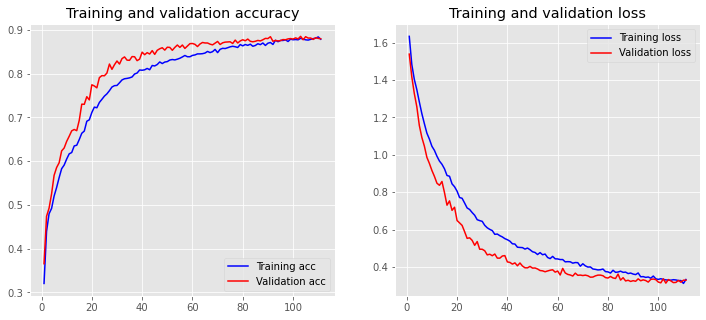

In [47]:
plot_history(history)